In [140]:
# IMPORTS
import numpy as np
import pandas as pd

#Fin Data Sources
import yfinance as yf
import pandas_datareader as pdr

#Data viz
import plotly.graph_objs as go
import plotly.graph_objects as go
import plotly.express as px

import math
import time
from datetime import date, timedelta
import datetime
import calendar

# for graphs
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.model_selection import train_test_split

# Q1

In [141]:
df_full_raw = pd.read_parquet("content/stocks_df_combined_2024_05_07.parquet.brotli")
df_full = df_full_raw[df_full_raw.Date>='2000-01-01']

In [142]:
TO_PREDICT = [g for g in df_full.keys() if (g.find('future')>=0)]

GROWTH = [g for g in df_full.keys() if (g.find('growth_')==0)&(g.find('future')<0)]

CUSTOM_NUMERICAL = ['SMA10', 'SMA20', 'growing_moving_average', 'high_minus_low_relative','volatility', 'ln_volume']

TECHNICAL_INDICATORS = ['adx', 'adxr', 'apo', 'aroon_1','aroon_2', 'aroonosc',
 'bop', 'cci', 'cmo','dx', 'macd', 'macdsignal', 'macdhist', 'macd_ext',
 'macdsignal_ext', 'macdhist_ext', 'macd_fix', 'macdsignal_fix',
 'macdhist_fix', 'mfi', 'minus_di', 'mom', 'plus_di', 'dm', 'ppo',
 'roc', 'rocp', 'rocr', 'rocr100', 'rsi', 'slowk', 'slowd', 'fastk',
 'fastd', 'fastk_rsi', 'fastd_rsi', 'trix', 'ultosc', 'willr',
 'ad', 'adosc', 'obv', 'atr', 'natr', 'ht_dcperiod', 'ht_dcphase',
 'ht_phasor_inphase', 'ht_phasor_quadrature', 'ht_sine_sine', 'ht_sine_leadsine',
 'ht_trendmod', 'avgprice', 'medprice', 'typprice', 'wclprice']

TECHNICAL_PATTERNS = [g for g in df_full.keys() if g.find('cdl')>=0]


MACRO = ['gdppot_us_yoy', 'gdppot_us_qoq', 'cpi_core_yoy', 'cpi_core_mom', 'FEDFUNDS',
 'DGS1', 'DGS5', 'DGS10']

In [143]:
NUMERICAL = GROWTH + TECHNICAL_INDICATORS + TECHNICAL_PATTERNS + CUSTOM_NUMERICAL + MACRO

In [144]:
df_full['is_positive_growth_5d_future']

3490    0
3491    0
3492    0
3493    0
3494    1
       ..
5422    0
5423    0
5424    0
5425    0
5426    0
Name: is_positive_growth_5d_future, Length: 182675, dtype: int64

In [145]:
def add_week_of_month(df, column):
    # Ensure the column is in datetime format
    df[column] = pd.to_datetime(df[column])
    
    # Calculate the week of the month
    df['WOM'] = df[column].apply(lambda x: f"{x.strftime('%b')}_w{math.ceil(x.day / 7.0)}")
    
    return df

In [146]:
df_full = add_week_of_month(df_full, 'Date')

In [147]:
CATEGORICAL = ['Month', 'Weekday', 'Ticker', 'ticker_type', 'WOM']

In [148]:
df_cate_onehot = pd.get_dummies(df_full[CATEGORICAL], dtype='int32')

In [149]:
df_cate_onehot.head()

,Month,Weekday,Ticker_AAPL,Ticker_ACN,Ticker_AMZN,Ticker_ASML,Ticker_AVGO,Ticker_BHARTIARTL.NS,Ticker_BRK-B,Ticker_CDI.PA,...,WOM_Oct_w1,WOM_Oct_w2,WOM_Oct_w3,WOM_Oct_w4,WOM_Oct_w5,WOM_Sep_w1,WOM_Sep_w2,WOM_Sep_w3,WOM_Sep_w4,WOM_Sep_w5
3490,2000-01-01,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3491,2000-01-01,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3492,2000-01-01,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3493,2000-01-01,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3494,2000-01-01,4,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [150]:
DUMMIES = df_cate_onehot.columns.to_list()

assert df_cate_onehot.keys().to_list() == DUMMIES

print(DUMMIES)

['Month', 'Weekday', 'Ticker_AAPL', 'Ticker_ACN', 'Ticker_AMZN', 'Ticker_ASML', 'Ticker_AVGO', 'Ticker_BHARTIARTL.NS', 'Ticker_BRK-B', 'Ticker_CDI.PA', 'Ticker_GOOG', 'Ticker_HDB', 'Ticker_HINDUNILVR.NS', 'Ticker_IBN', 'Ticker_IDEXY', 'Ticker_INFY', 'Ticker_ITC.NS', 'Ticker_JPM', 'Ticker_LICI.NS', 'Ticker_LLY', 'Ticker_LT.NS', 'Ticker_MC.PA', 'Ticker_META', 'Ticker_MSFT', 'Ticker_NVDA', 'Ticker_NVO', 'Ticker_OR.PA', 'Ticker_RELIANCE.NS', 'Ticker_RMS.PA', 'Ticker_SAP', 'Ticker_SBIN.NS', 'Ticker_SIE.DE', 'Ticker_TCS.NS', 'Ticker_TTE', 'Ticker_V', 'ticker_type_EU', 'ticker_type_INDIA', 'ticker_type_US', 'WOM_Apr_w1', 'WOM_Apr_w2', 'WOM_Apr_w3', 'WOM_Apr_w4', 'WOM_Apr_w5', 'WOM_Aug_w1', 'WOM_Aug_w2', 'WOM_Aug_w3', 'WOM_Aug_w4', 'WOM_Aug_w5', 'WOM_Dec_w1', 'WOM_Dec_w2', 'WOM_Dec_w3', 'WOM_Dec_w4', 'WOM_Dec_w5', 'WOM_Feb_w1', 'WOM_Feb_w2', 'WOM_Feb_w3', 'WOM_Feb_w4', 'WOM_Feb_w5', 'WOM_Jan_w1', 'WOM_Jan_w2', 'WOM_Jan_w3', 'WOM_Jan_w4', 'WOM_Jan_w5', 'WOM_Jul_w1', 'WOM_Jul_w2', 'WOM_Jul_w3', 

In [151]:
df_with_dummies = pd.concat([df_full, df_cate_onehot], axis=1)

In [152]:
df_with_dummies.head(5)

,Open,High,Low,Close,Adj Close_x,Volume,Ticker,Year,Month,Weekday,...,WOM_Oct_w1,WOM_Oct_w2,WOM_Oct_w3,WOM_Oct_w4,WOM_Oct_w5,WOM_Sep_w1,WOM_Sep_w2,WOM_Sep_w3,WOM_Sep_w4,WOM_Sep_w5
3490,58.68750,59.3125,56.00000,58.28125,36.065567,53228400.0,MSFT,2000,2000-01-01,0,...,0,0,0,0,0,0,0,0,0,0
3491,56.78125,58.5625,56.12500,56.31250,34.847271,54119000.0,MSFT,2000,2000-01-01,1,...,0,0,0,0,0,0,0,0,0,0
3492,55.56250,58.1875,54.68750,56.90625,35.214706,64059600.0,MSFT,2000,2000-01-01,2,...,0,0,0,0,0,0,0,0,0,0
3493,56.09375,56.9375,54.18750,55.00000,34.035072,54976600.0,MSFT,2000,2000-01-01,3,...,0,0,0,0,0,0,0,0,0,0
3494,54.31250,56.1250,53.65625,55.71875,34.479843,62013600.0,MSFT,2000,2000-01-01,4,...,0,0,0,0,0,0,0,0,0,0


In [153]:
df_with_dummies.info()

<class 'pandas.core.frame.DataFrame'>
Index: 182675 entries, 3490 to 5426
Columns: 301 entries, Open to WOM_Sep_w5
dtypes: datetime64[ns](4), float64(128), int32(161), int64(5), object(3)
memory usage: 308.7+ MB


In [154]:
df_with_dummies['is_positive_growth_5d_future']

3490    0
3491    0
3492    0
3493    0
3494    1
       ..
5422    0
5423    0
5424    0
5425    0
5426    0
Name: is_positive_growth_5d_future, Length: 182675, dtype: int64

In [155]:
TARGETS = DUMMIES + ['is_positive_growth_5d_future']

In [156]:
df_corr = df_with_dummies[TARGETS].drop(['Month','Weekday'], axis=1).corr()['is_positive_growth_5d_future'].reset_index().sort_values('is_positive_growth_5d_future', ascending=False)

In [157]:
df_corr.head()

,index,is_positive_growth_5d_future
96,is_positive_growth_5d_future,1.000000
74,WOM_Mar_w4,0.026058
90,WOM_Oct_w5,0.026023
79,WOM_May_w4,0.022264
49,WOM_Dec_w4,0.019270


# Q2

In [158]:
df_with_dummies_q2 = df_with_dummies.copy()

In [159]:
pd.options.mode.chained_assignment = None  # default='warn'

df_with_dummies_q2.replace([np.inf, -np.inf], np.nan, inplace=True)

# Need to fill NaNs somehow
df_with_dummies_q2.fillna(0, inplace=True)

In [160]:
df_with_dummies_q2['pred3_manual_gdp_fastd'] = ((df_with_dummies_q2['gdppot_us_yoy'] <= 0.027) & (df_with_dummies_q2['fastd'] >= 0.251)).astype(int)
df_with_dummies_q2['pred3_manual_gdp_fastd'].value_counts()

pred3_manual_gdp_fastd
1    166242
0     16433
Name: count, dtype: int64

In [161]:
df_with_dummies_q2['pred4_manual_gdp_wti_oil'] = ((df_with_dummies_q2['gdppot_us_yoy'] >= 0.027) & (df_with_dummies_q2['growth_wti_oil_30d'] <= 1.005)).astype(int)
df_with_dummies_q2['pred4_manual_gdp_wti_oil'].value_counts()

pred4_manual_gdp_wti_oil
0    172493
1     10182
Name: count, dtype: int64

In [162]:
PREDICTIONS = [k for k in df_with_dummies_q2.keys() if k.startswith('pred')]
PREDICTIONS

['pred3_manual_gdp_fastd', 'pred4_manual_gdp_wti_oil']

In [163]:
def temporal_split(df, min_date, max_date, train_prop=0.7, val_prop=0.15, test_prop=0.15):
    """
    Splits a DataFrame into three buckets based on the temporal order of the 'Date' column.

    Args:
        df (DataFrame): The DataFrame to split.
        min_date (str or Timestamp): Minimum date in the DataFrame.
        max_date (str or Timestamp): Maximum date in the DataFrame.
        train_prop (float): Proportion of data for training set (default: 0.6).
        val_prop (float): Proportion of data for validation set (default: 0.2).
        test_prop (float): Proportion of data for test set (default: 0.2).

    Returns:
        DataFrame: The input DataFrame with a new column 'split' indicating the split for each row.
    """
    # Define the date intervals
    train_end = min_date + pd.Timedelta(days=(max_date - min_date).days * train_prop)
    val_end = train_end + pd.Timedelta(days=(max_date - min_date).days * val_prop)

    # Assign split labels based on date ranges
    split_labels = []
    for date in df['Date']:
        if date <= train_end:
            split_labels.append('train')
        elif date <= val_end:
            split_labels.append('validation')
        else:
            split_labels.append('test')

    # Add 'split' column to the DataFrame
    df['split'] = split_labels

    return df

In [164]:
min_date_df = df_with_dummies_q2.Date.min()
max_date_df = df_with_dummies_q2.Date.max()

df_with_dummies_q2 = temporal_split(df_with_dummies_q2,
                                 min_date = min_date_df,
                                 max_date = max_date_df)

In [165]:
df_with_dummies_q2['split'].value_counts()/len(df_with_dummies_q2)

split
train         0.675834
test          0.163290
validation    0.160876
Name: count, dtype: float64

In [166]:
df_with_dummies_q2[df_with_dummies_q2['split'] == 'test']['pred3_manual_gdp_fastd'].value_counts()

pred3_manual_gdp_fastd
1    29822
0        7
Name: count, dtype: int64

In [167]:
df_with_dummies_q2[df_with_dummies_q2['split'] == 'test']['pred4_manual_gdp_wti_oil'].value_counts()

pred4_manual_gdp_wti_oil
0    29829
Name: count, dtype: int64

In [168]:
df_with_dummies_q2[df_with_dummies_q2['split'] != 'test'].Date.max()

Timestamp('2020-09-11 00:00:00')

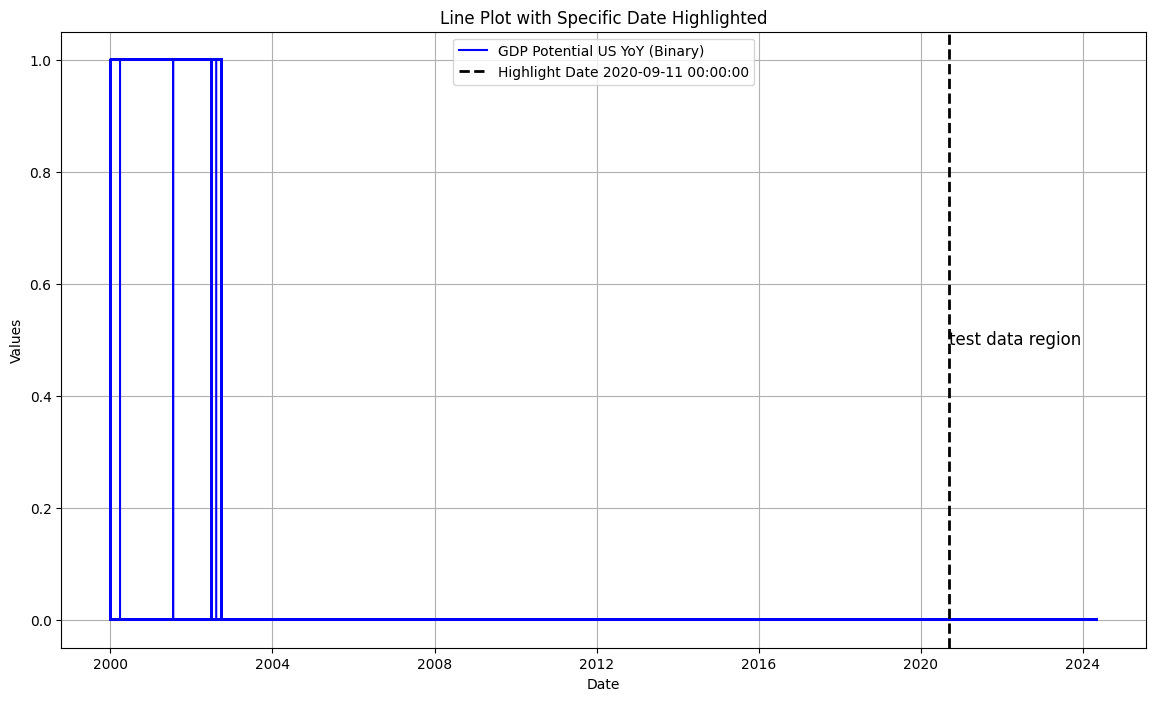

In [169]:
df = df_with_dummies_q2.copy()

df['Date'] = pd.to_datetime(df['Date'])
df['gdppot_us_yoy_binary'] = np.where(df['gdppot_us_yoy'] >= 0.027, 1, 0)


plt.figure(figsize=(14, 8))
plt.step(df['Date'], df['gdppot_us_yoy_binary'], where='post', label='GDP Potential US YoY (Binary)', color='blue')

# Draw a black line at the specified datehighlight_date = '2020-09-14'
highlight_date = df[df['split'] != 'test'].Date.max()
plt.axvline(pd.Timestamp(highlight_date), color='black', linestyle='--', linewidth=2, label=f'Highlight Date {highlight_date}')


plt.text(pd.Timestamp(highlight_date), 0.5, 'test data region', rotation=0, verticalalignment='center', color='black', fontsize=12)


# Add labels and title
plt.xlabel('Date')
plt.ylabel('Values')
plt.title('Line Plot with Specific Date Highlighted')
plt.legend()

# Show plot
plt.grid(True)
plt.show()

- The reason of why there is no positive value in pred4 is because all gdppot_us_yoy value in test_data is less than 0.027
- This is the crons of using index to split train and test set.
- The better choice is using train_test_split

In [173]:
test_idx = df_with_dummies_q2['split'].isin(['test'])
value_counts = df_with_dummies_q2.loc[test_idx, 'is_positive_growth_5d_future'].value_counts()

In [174]:
portion_of_1 = value_counts[1] / (value_counts[1] + value_counts[0])
print(portion_of_1)

0.5551979617151095


# Q3